In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import pandas as pd
%matplotlib inline

print(tf.__version__)

2.11.0


## Dataset

Download e preparação dos dados

In [2]:
# Esta célula faz o download do dataset completo
Sample_dataset = tfds.load("oxford_iiit_pet", split="train", try_gcs=True)
assert isinstance(Sample_dataset, tf.data.Dataset)
Sample_dataset 

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [3]:
path_csv = "C:/Users/Micro/Desktop/oxford_iiit_pet.csv"
path_images = "C:/Users/Micro/tensorflow_datasets/downloads/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_imagesZxlcXhwB8atfm2pdIrjCelgNiW7ORYkX5h1Fkzf6MY0.tar.gz/images/"
formato = [".jpg", ".png"]

# Nesse dataset, os dados são separados por espaços, e as colunas não vem nomeadas
# por isso o seguinte tratamento
oxford_iiit_pet_dataset = pd.read_csv(path_csv, sep = " ", names ="Image CLASS_ID SPECIES BREED_ID".split())

# As imagens estão registradas apenas com o nome, então é adicionado o caminho local
# e em seguida é transformada em uma matriz compreensível para o matplotlib
oxford_iiit_pet_dataset["Image"] = [path_images + str(nome_img) + formato[0] for nome_img in oxford_iiit_pet_dataset["Image"]]

In [4]:
classes_names = ['gato', 'cachorro'] # 0: gato, 1: cachorro

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img

In [6]:
inputs_shape = (64,64) 
oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize(inputs_shape, Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
oxford_iiit_pet_dataset["Image"] = [img_to_array(img) for img in oxford_iiit_pet_dataset["Image"]]
#oxford_iiit_pet_dataset.tail() # as últimas linhas do dataframe

C:\Users\Micro\AppData\Local\Temp\ipykernel_12120\642115867.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize(inputs_shape, Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
C:\Users\Micro\AppData\Local\Temp\ipykernel_12120\642115867.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize(inputs_shape, Image.ANTIALIAS) for img in oxfo

## Separação dos dados de treino e de teste

In [7]:
X = oxford_iiit_pet_dataset["Image"] # Conjunto de dados
y = oxford_iiit_pet_dataset["SPECIES"] # Conjunto "alvo / classe"

In [8]:
print(X.shape)
print(X[0].shape)
print(type(X), type(y))

(3680,)
(64, 64, 3)
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [9]:
# divisão dos dados de teste (60%) e treino (40%)
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=101)


print(type(train_images), type(train_labels))

test_labels = test_labels.apply(lambda label: label - 1 )
train_labels = train_labels.apply(lambda label: label - 1 )

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

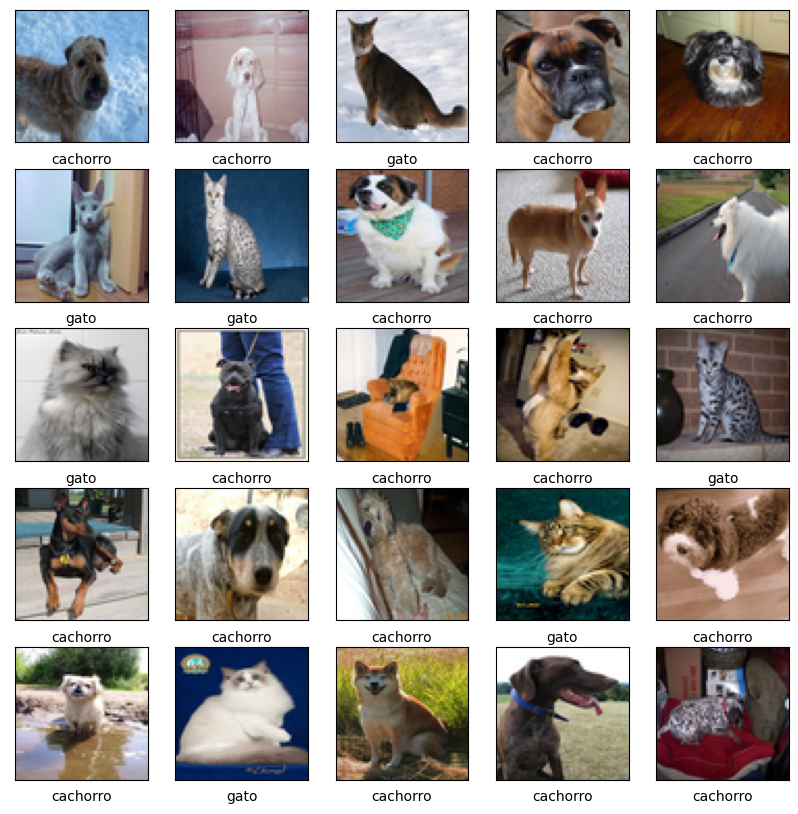

In [11]:
plt.figure(figsize=(10,10))

for i, x in enumerate(list(train_images.index[:25])):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(array_to_img(train_images[x]), cmap=plt.cm.binary)
    plt.xlabel(classes_names[train_labels[x]])
plt.show()

In [12]:
print(len(train_labels))
print(train_images.shape)
print(test_images.shape)

2208
(2208,)
(1472,)


In [13]:
n = np.asarray([train_images[x] for x in train_images.index])
m = np.asarray([test_images[x] for x in test_images.index])

train_images = n
test_images = m

print(train_images.shape, "\t", test_images.shape)

(2208, 64, 64, 3) 	 (1472, 64, 64, 3)


# Pré-processamento dos dados

Inspeção imagem

IMG shape (64, 64, 3)


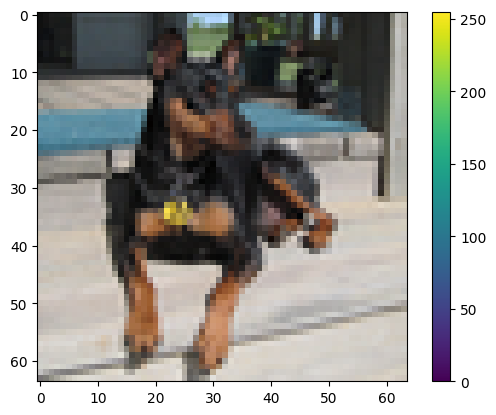

In [14]:
from tensorflow.keras.utils import array_to_img
print("IMG shape", train_images[0].shape)
plt.figure()
plt.imshow(array_to_img(train_images[15]))
plt.colorbar()
plt.grid(False)
plt.show()

## Escalaremos esses valores no intervalo de 0 e 1

In [15]:
#train_images = train_images / 255.0
#test_images = test_images / 255.0

# Contrução do Modelo

In [18]:


model = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / 255.,
	      input_shape =  (64, 64, 3)
    ),
    tf.keras.models.Sequential([
	      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
	      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [19]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

In [20]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ["accuracy", "mape"]
)

In [21]:
historico = model.fit(x = train_images, y = train_labels, validation_data = (test_images, test_labels), epochs=15, batch_size=32)

Epoch 1/15
69/69 [==============================] - 28s 334ms/step - loss: 0.6264 - accuracy: 0.6793 - mape: 207563280.0000 - val_loss: 0.6532 - val_accuracy: 0.6610 - val_mape: 256783856.0000
Epoch 2/15
69/69 [==============================] - 20s 289ms/step - loss: 0.5992 - accuracy: 0.6893 - mape: 205650576.0000 - val_loss: 0.7554 - val_accuracy: 0.6610 - val_mape: 284683872.0000
Epoch 3/15
69/69 [==============================] - 20s 294ms/step - loss: 0.5825 - accuracy: 0.6902 - mape: 197472768.0000 - val_loss: 0.5965 - val_accuracy: 0.6821 - val_mape: 202661024.0000
Epoch 4/15
69/69 [==============================] - 21s 301ms/step - loss: 0.5682 - accuracy: 0.6925 - mape: 187551328.0000 - val_loss: 0.7702 - val_accuracy: 0.6624 - val_mape: 276290432.0000
Epoch 5/15
69/69 [==============================] - 22s 313ms/step - loss: 0.5651 - accuracy: 0.7101 - mape: 194226160.0000 - val_loss: 0.5868 - val_accuracy: 0.6929 - val_mape: 220550048.0000
Epoch 6/15
69/69 [=================

In [22]:
score = model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
model.evaluate(tf.expand_dims(test_images, axis=-1))
#print('\nTest accuracy:', test_acc*100, '\nTest loss:', test_loss*100)

accuracy: 70.11%
46/46 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - mape: 0.0000e+00


[0.0, 0.0, 0.0]

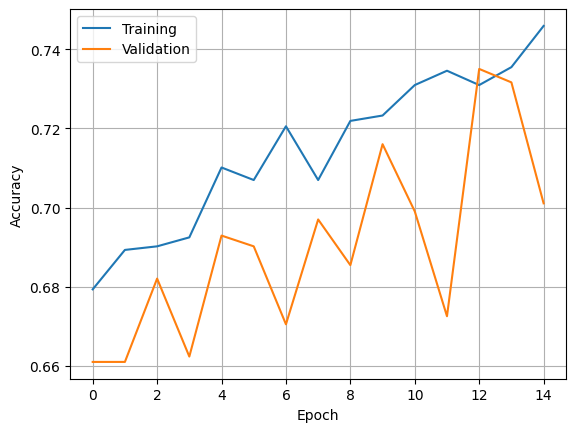

In [23]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

Text(0.5, 1.0, 'Mean absolute percentage error (MAPE)')

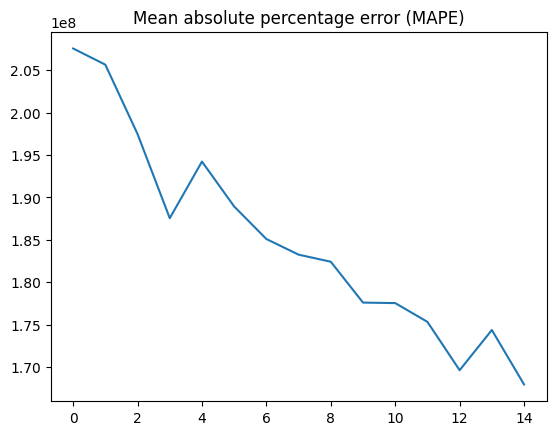

In [24]:
plt.plot(historico.history["mape"])
plt.title("Mean absolute percentage error (MAPE)")

In [25]:
predictions = model.predict(test_images)

46/46 [==============================] - 3s 60ms/step


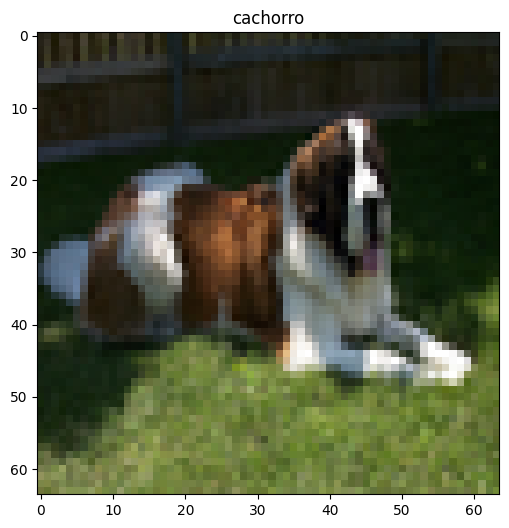

In [29]:
i = 3
plt.figure(figsize=(12,6))
#plt.subplot(1,2)
plt.imshow(test_images[i] / 255)
plt.title(classes_names[int(predictions[i][0] > 0.5)])
plt.show()

In [30]:
cats = []
for i in range(1472): 
  if(predictions[i][0] <= 0.5):
    cats.append(i)
print(len(cats))
cats[:10]

99


[25, 29, 82, 128, 197, 201, 205, 238, 246, 250]

<Figure size 2000x500 with 0 Axes>

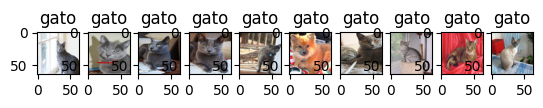

In [31]:
plt.figure(figsize=(20,5))
fig, ax = plt.subplots(1, 10)
for i,x in enumerate(cats[:10]):
    predictedLabel = int(predictions[x] >= 0.5)
    ax[i].set_title(classes_names[predictedLabel])
    ax[i].imshow(test_images[x] / 255)

In [32]:
resultados = {}
for i in test_labels.index:
    classe_esperada = test_labels[i]
    classe_predita = model.predict(np.expand_dims(X_test[i], 0), verbose = False)
    resultados[i] = [classe_esperada, int(classe_predita[0][0] > 0.5)]


In [33]:
diff = []
for v in resultados.values():
  if(v[0] != v[1]):
    diff.append(0)
  else:
    diff.append(100)

diff = pd.DataFrame(diff)

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

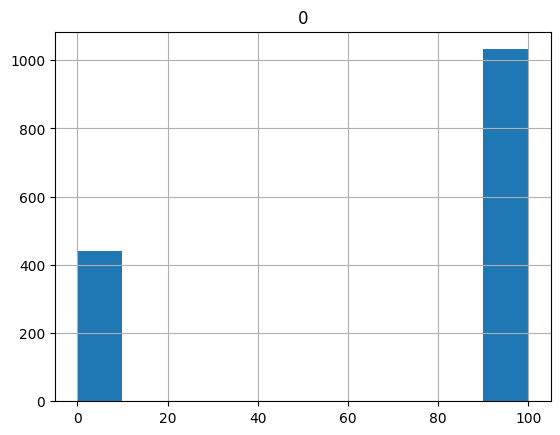

In [34]:
diff.hist()

1/1 [==============================] - 0s 99ms/step


C:\Users\Micro\AppData\Local\Temp\ipykernel_12120\550222305.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  test_image = Image.open(pimg).convert('RGB').resize(inputs_shape, Image.ANTIALIAS)


r:  0.42949584 0 0
Gato


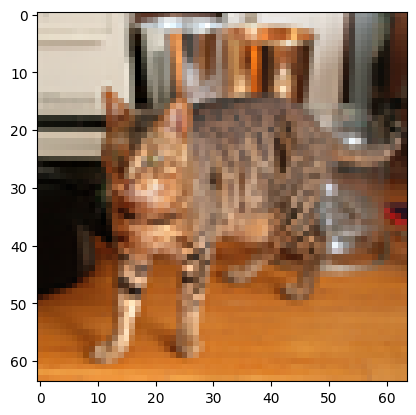

In [36]:
import numpy as np
from keras.preprocessing import image

#pimg = path_images + "Ragdoll_149.jpg"
pimg = "C:/Users/Micro/Desktop/images/Bengal_29.jpg"
test_image = Image.open(pimg).convert('RGB').resize(inputs_shape, Image.ANTIALIAS)
plt.imshow(test_image)

test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print("r: ", result[0][0], np.argmax(result), int(result[0][0] >= 0.5))
if (int(result[0][0] >= 0.5) == 1):
    prediction = 'Cachorro'
else:
    prediction = 'Gato'

print(prediction)


In [37]:
#salvando o modelo treinado
model.save('teste-004.h5')

In [38]:
model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model-weights3.h5")

In [39]:
from keras.models import model_from_json
json_file = open('model4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [41]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.load_weights("C:/Users/Micro/Desktop/model-weights3.h5")

score = loaded_model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 70.11%
